In [3]:
%cd '../HOTS'
from Tools import netparam, knn, JensenShannon, BattachaNorm, fit_jitter
import numpy as np
import matplotlib.pyplot as plt
import pickle
from os.path import isfile
import torch

/home/antoine/homhots/HOTS/HOTS


In [4]:
def printfig(fig, name):
    dpi_exp = None
    bbox = 'tight'
    path = '../../paper/5f22d412742c360001c92b46/fig/'
    #path = '../../GrimaldiEtAl2020HOTS_clone_laurent/fig'
    fig.savefig(path+name, dpi = dpi_exp, bbox_inches=bbox, transparent=True)

# Testing on the full dataset

In [5]:
sigma = None
pooling = False
homeinv = False
jitonic = [None,None] #[temporal, spatial]
jitter = False
R = 2
tau = 5
nbclust = [4,8,16]
filt = 2

timestr = '2021-03-29'
record_path = '../Records/EXP_03_NMNIST/'
dataset = 'nmnist'
nb_train = 60000
nb_test = 10000
ds = 1

nb_test = nb_test//ds
nb_train = nb_train//ds
print(f'training set size: {nb_train} - testing set: {nb_test}')

kNN = 12
verbose=False

training set size: 60000 - testing set: 10000


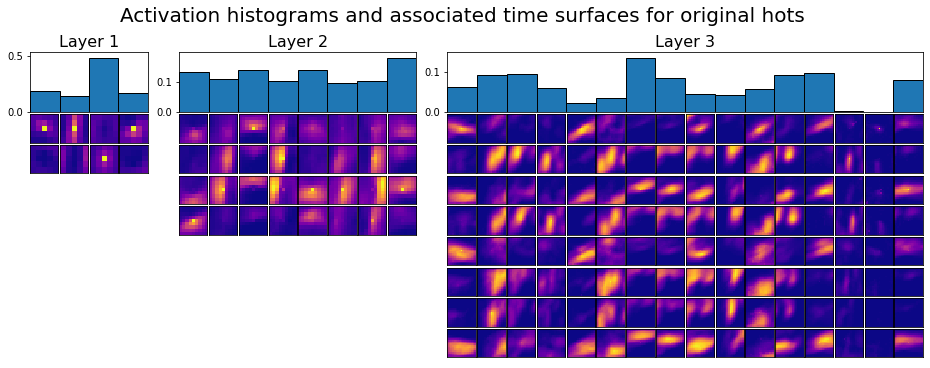

----------Averaged histograms----------
Performances for hots with Euclidian distance: 37.7%
Performances for hots with Bhattacharyya distance: 37.9%
Performances for hots with Jensen-Shannon distance: 37.9%
---------Per sample histograms---------
Performances for hots with  k-NN (k=12): 86.9%


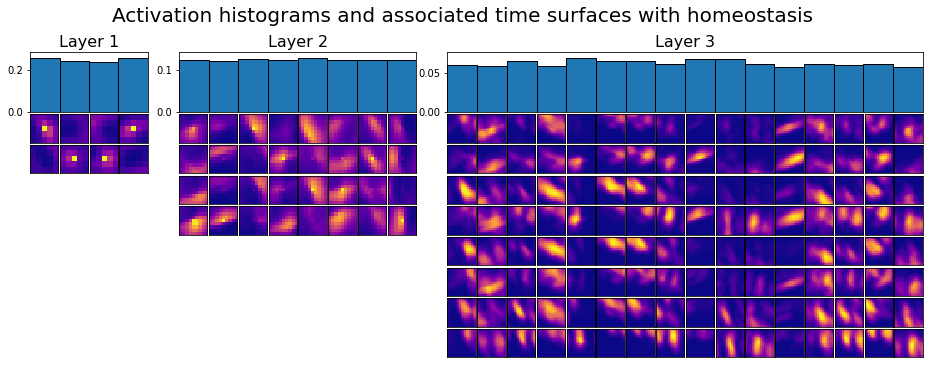

----------Averaged histograms----------
Performances for homhots with Euclidian distance: 44.0%
Performances for homhots with Bhattacharyya distance: 45.800000000000004%
Performances for homhots with Jensen-Shannon distance: 45.9%
---------Per sample histograms---------
Performances for homhots with  k-NN (k=12): 87.7%


In [4]:
for name in ['hots', 'homhots']:
    f_name = f'{record_path}{timestr}_results_fullset_histo_{name}.pkl'
    hotshom, homeotest = netparam(name, filt, tau, nbclust, sigma, homeinv, jitter, timestr, dataset, R)#, nb_learn=50)
    hotshom.plotlayer()
    if isfile(f_name):
        with open(f_name, 'rb') as file:
            scores = pickle.load(file)
    else:
        trainhistomap = hotshom.running(homeotest=homeotest, nb_digit = nb_train, outstyle='histo', dataset=dataset, verbose=verbose)
        testhistomap = hotshom.running(homeotest = homeotest, train=False, nb_digit=nb_test, jitonic=jitonic, dataset=dataset, verbose=verbose)
        JS_kNN_score = knn(trainhistomap,testhistomap, k = kNN, weights = 'distance', metric = JensenShannon)
        kNN_score = knn(trainhistomap,testhistomap, k = kNN, weights = 'distance')
        
        trainhistomapav = hotshom.running(homeotest=homeotest, nb_digit = nb_train, outstyle='histav', dataset=dataset, verbose=verbose)
        trainhistomapav2 = []
        for i in range(trainhistomapav.shape[0]):
            trainhistomapav2.append([i,trainhistomapav[i,:]])
        JS_score = knn(trainhistomapav2,testhistomap, k = 1, weights = 'uniform', metric = JensenShannon)
        BA_score = knn(trainhistomapav2,testhistomap, k = 1, weights = 'uniform', metric = BattachaNorm)
        EU_score = knn(trainhistomapav2,testhistomap, k = 1, weights = 'uniform')

        scores = [EU_score, BA_score, JS_score, kNN_score, JS_kNN_score]
        with open(f_name, 'wb') as file:
            pickle.dump(scores, file, pickle.HIGHEST_PROTOCOL)
        
    print('----------Averaged histograms----------')
    print(f'Performances for {name} with Euclidian distance: {np.round(scores[0],3)*100}%')
    print(f'Performances for {name} with Bhattacharyya distance: {np.round(scores[1],3)*100}%')
    print(f'Performances for {name} with Jensen-Shannon distance: {np.round(scores[2],3)*100}%')
    print('---------Per sample histograms---------')
    print(f'Performances for {name} with  k-NN (k={kNN}): {np.round(scores[3],3)*100}%')
    #print(f'Performances for {name} with  k-NN using Jensen-Shannon as a metric (k={kNN}): {np.round(scores[4],3)*100}%')

# Testing on different folds

- trainset is composed of all avaible samples: 60 000 digits
- testset is divided into 10 folds of 1000 samples each

In [9]:
nb_test = 10000
ds = 10
nb_test = nb_test//ds
print(f'training set size: {nb_train} - testing set: {nb_test}')

training set size: 60000 - testing set: 1000


In [5]:
verbose = False
for name in ['hots','homhots']:
    f_name = f'{record_path}{timestr}_results_kfolds_{nb_test}_histo_{name}.pkl'
    hotshom, homeotest = netparam(name, filt, tau, nbclust, sigma, homeinv, jitter, timestr, dataset, R)#, nb_learn=50)
    trainhistomap = hotshom.running(homeotest=homeotest, nb_digit=nb_train, outstyle='histo', verbose = verbose)
    if isfile(f_name):
        with open(f_name, 'rb') as file:
            scores = pickle.load(file)
        print('results loaded')
    else:
        scores = []
        for i in range(ds):
            testhistomap = hotshom.running(homeotest=homeotest, train=False, nb_digit=nb_test, jitonic=jitonic, kfold = ds, kfold_ind=i, verbose=verbose)
            kNN_score = knn(trainhistomap,testhistomap, k = kNN, weights = 'distance')
            scores.append(kNN_score)
        with open(f_name, 'wb') as file:
            pickle.dump(scores, file, pickle.HIGHEST_PROTOCOL)
    print(f'Mean accuracy for {name} = {np.round(np.mean(scores),3)*100}% - std = {np.round(np.std(scores),3)*100}')

results loaded
Mean accuracy for hots = 87.0% - std = 1.0
results loaded
Mean accuracy for homhots = 87.9% - std = 1.4000000000000001


# Testing with different spatial and temporal jitter

- trainset is composed of all avaible samples: 60 000 digits
- testset is a subset composed of 1000 samples of the N-MNIST testset
- spatial and temporal jitter are applied separately to the testset

In [7]:
from scipy.stats import beta

jit_s = np.arange(0,10,0.5)
jit_t = np.arange(0,300,10)
jit_s, jit_t = jit_s**2, jit_t**2

nb_trials = 10

../Records/EXP_03_NMNIST/2021-03-29_results_jitter_1000_histo_homhots.pkl
results loaded
../Records/EXP_03_NMNIST/2021-03-29_results_jitter_1000_histo_hots.pkl
results loaded


  0%|          | 4/10000 [01:07<47:07:51, 16.97s/it]


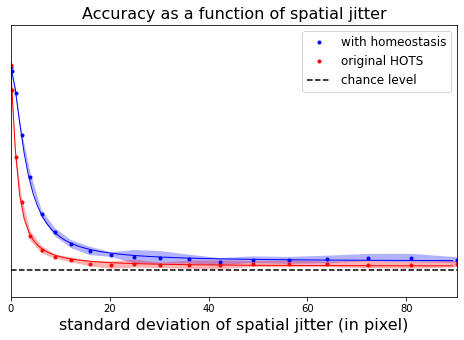

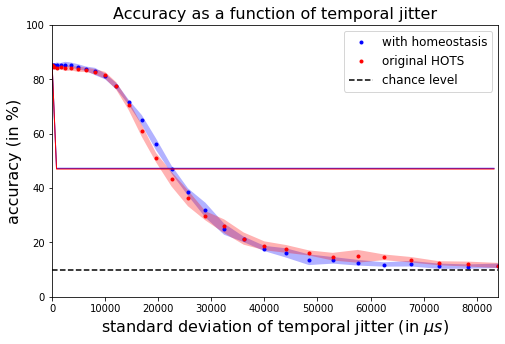

In [11]:
verbose = True
fig_s, ax_s = plt.subplots(1,1,figsize=(8,5))
fig_t, ax_t = plt.subplots(1,1,figsize=(8,5))

for name in ['homhots', 'hots']:
    f_name = f'{record_path}{timestr}_results_jitter_{nb_test}_histo_{name}.pkl'
    print(f_name)
    if isfile(f_name):
        with open(f_name, 'rb') as file:
            score_t1, score_t12, jit_t, score_s1, score_s12, jit_s = pickle.load(file)
        print('results loaded')
    else:
        hotshom, homeotest = netparam(name, filt, tau, nbclust, sigma, homeinv, jitter, timestr, dataset, R)
        trainhistomap = hotshom.running(homeotest=homeotest, nb_digit=nb_train, outstyle='histo')
        score_s1 = np.zeros([nb_trials, len(jit_s)])
        score_t1 = np.zeros([nb_trials, len(jit_t)])
        score_s12 = np.zeros([nb_trials, len(jit_s)])
        score_t12 = np.zeros([nb_trials, len(jit_t)])
        for trial in range(nb_trials):
            hotshom.date = '2021-03-29_'+str(trial)
            id_jit = 0
            for i in jit_s:
                i = round(i,2)
                jitonic = [None,i]
                if i==0:
                    jitonic= [None,None]
                #if isfile(f'{record_path}/test/'+hotshom.get_fname()+f'_{nb_test}_{jitonic}_histo.pkl'):
                testhistomap = hotshom.running(homeotest = homeotest, train=False, nb_digit=nb_test, jitonic=jitonic, subset_size = nb_test, verbose = verbose)
                kNN12_score = knn(trainhistomap,testhistomap, k = kNN, weights = 'distance')
                kNN1_score = knn(trainhistomap,testhistomap, k = 1, weights = 'distance')
                score_s1[trial,id_jit] = kNN1_score
                score_s12[trial,id_jit] = kNN12_score
                id_jit+=1
                
            id_jit = 0
            for j in jit_t:
                j = round(j,0)
                jitonic = [j,None]
                if j==0:
                    jitonic= [None,None]
                #if isfile(f'{record_path}/test/'+hotshom.get_fname()+f'_{nb_test}_{jitonic}_histo.pkl'):
                testhistomap = hotshom.running(homeotest = homeotest, train=False, nb_digit=nb_test, jitonic=jitonic, subset_size = nb_test, verbose = verbose)
                kNN12_score = knn(trainhistomap,testhistomap, k = kNN, weights = 'distance')
                kNN1_score = knn(trainhistomap,testhistomap, k = 1, weights = 'distance')
                score_t1[trial,id_jit] = kNN1_score
                score_t12[trial,id_jit] = kNN12_score
                id_jit+=1
                
        with open(f_name, 'wb') as file:
            pickle.dump([score_t1, score_t12, jit_t, score_s1, score_s12, jit_s], file, pickle.HIGHEST_PROTOCOL)
            
    #jit_t_plot, jit_s_plot = np.sqrt(jit_t), np.sqrt(jit_s)
    jit_t_plot, jit_s_plot = jit_t, jit_s

    score_t12=score_t12[:9,:]
    score_s12=score_s12[:9,:]
    
    score_stat1 = np.zeros([3,len(jit_t)])
    score_stat12 = np.zeros([3,len(jit_t)])
    score_stas1 = np.zeros([3,len(jit_s)])
    score_stas12 = np.zeros([3,len(jit_s)])
    q = [0.05,0.5,0.95]
    for i in range(1,score_t1.shape[1]):
        mean = np.mean(score_t1[:,i])
        var = np.std(score_t1[:,i])
        alpha1=mean**2*(1-mean)/var-mean
        beta1=alpha1*(1-mean)/mean
        mean = np.mean(score_t12[:,i])
        var = np.std(score_t12[:,i])
        alpha12=mean**2*(1-mean)/var-mean
        beta12=alpha1*(1-mean)/mean
        #paramz_t1 = beta.fit(score_t1[:,i], a=alpha1, b=beta1, floc=0, fscale = 1)
        paramz_t12 = beta.fit(score_t12[:,i], a=alpha12, b=beta12, floc=0, fscale = 1)
        #score_stat1[0,i], score_stat1[1,i], score_stat1[2,i] = beta.ppf(q, a=paramz_t1[0], b=paramz_t1[1])
        score_stat12[0,i], score_stat12[1,i], score_stat12[2,i] = beta.ppf(q, a=paramz_t12[0], b=paramz_t12[1])
        score_stat1[1,i], score_stat12[1,i] = np.mean(score_t1[:,i]), np.mean(score_t12[:,i])
        
    for j in range(1,score_s1.shape[1]):
        mean = np.mean(score_s1[:,j])
        var = np.std(score_s1[:,j])
        alpha1=mean**2*(1-mean)/var-mean
        beta1=alpha1*(1-mean)/mean
        mean = np.mean(score_s12[:,j])
        var = np.std(score_s12[:,j])
        alpha12=mean**2*(1-mean)/var-mean
        beta12=alpha1*(1-mean)/mean
        #paramz_s1 = beta.fit(score_s1[:,j], a=alpha1, b=beta1, floc=0, fscale = 1)
        paramz_s12 = beta.fit(score_s12[:,j], a=alpha12, b=beta12, floc=0, fscale = 1)
        #score_stas1[0,j], score_stas1[1,j], score_stas1[2,j] = beta.ppf(q, a=paramz_s1[0], b=paramz_s1[1])
        score_stas12[0,j], score_stas12[1,j], score_stas12[2,j] = beta.ppf(q, a=paramz_s12[0], b=paramz_s12[1])
        score_stas1[1,j], score_stas12[1,j] = np.mean(score_s1[:,j]), np.mean(score_s12[:,j])
        
    score_stat12[:,0] = np.mean(score_t12[:,0])
    score_stas12[:,0] = np.mean(score_s12[:,0])
    if name == 'hots':
        #param_T = [-1.9, 145, np.log(20*np.ones(1))]
        #param_S = [-2, 1, np.log(0.4*np.ones(1))]
        param_T = [0.8, 140, 8, 0.1]
        param_S = [0.8, 1, 3, 0.1]
    else: 
        #param_T = [-1.9, 150, np.log(20*np.ones(1))]
        #param_S = [-1.9, 2, np.log(0.5*np.ones(1))]
        param_T = [0.8, 150, 8, 0.1]
        param_S = [0.8, 2, 2, 0.1]
    n = 513
    logistic_model_T, loss_T, fit_T = fit_jitter(param_T, jit_t_plot, np.array(score_stat12[1,:]), num_epochs=n, verbose=False) 
    logistic_model_S, loss_S, fit_S = fit_jitter(param_S, jit_s_plot, np.array(score_stas12[1,:]), num_epochs=n, verbose=False) 
    
    x_fit_S = np.arange(jit_s_plot[0],jit_s_plot[-1],(jit_s_plot[-1]-jit_s_plot[0])/100)
    x_fit_T = np.arange(jit_t_plot[0],jit_t_plot[-1],(jit_t_plot[-1]-jit_t_plot[0])/100)
    
    if name=='hots':
        #ax_s.plot(jit_s_plot, score_stas1[1,:]*100, '-',color='orange', label='HOTS (k=1)')
        #ax_s.fill_between(jit_s_plot,
        #    score_stas1[2,:]*100, score_stas1[0,:]*100,
        #    facecolor = 'orange', edgecolor = None, alpha = .3)
        
        ax_s.plot(jit_s_plot, score_stas12[1,:]*100, '.',color='red', label='original HOTS')
        ax_s.plot(x_fit_S, fit_S.detach().numpy()*100, color='red', lw=1)
        ax_s.fill_between(jit_s_plot,
            score_stas12[2,:]*100, score_stas12[0,:]*100,
            facecolor = 'red', edgecolor = None, alpha = .3)
        
        #ax_t.plot(jit_t_plot, score_stat1[1,:]*100, '-',color='orange', label='HOTS (k=1)')
        #ax_t.fill_between(jit_t_plot,
        #    score_stat1[2,:]*100, score_stat1[0,:]*100,
        #    facecolor = 'orange', edgecolor = None, alpha = .3)
        
        ax_t.plot(jit_t_plot, score_stat12[1,:]*100, '.',color='red', label='original HOTS')
        ax_t.plot(x_fit_T, fit_T.detach().numpy()*100, color='red', lw=1)
        ax_t.fill_between(jit_t_plot,
            score_stat12[2,:]*100, score_stat12[0,:]*100,
            facecolor = 'red', edgecolor = None, alpha = .3)
    else:
        #ax_s.plot(jit_s_plot, score_stas1[1,:]*100, '-',color='cyan', label='HOTS with homeostasis (k=1)')
        #ax_s.fill_between(jit_s_plot,
        #    score_stas1[2,:]*100, score_stas1[0,:]*100,
        #    facecolor = 'cyan', edgecolor = None, alpha = .3)
        
        ax_s.plot(jit_s_plot, score_stas12[1,:]*100, '.',color='blue', label='with homeostasis')
        ax_s.plot(x_fit_S, fit_S.detach().numpy()*100, color='blue', lw=1)
        ax_s.fill_between(jit_s_plot,
            score_stas12[2,:]*100, score_stas12[0,:]*100,
            facecolor = 'blue', edgecolor = None, alpha = .3)
        
        #ax_t.plot(jit_t_plot, score_stat1[1,:]*100, '-',color='cyan', label='HOTS with homeostasis (k=1)')
        #ax_t.fill_between(jit_t_plot,
        #    score_stat1[2,:]*100, score_stat1[0,:]*100,
        #    facecolor = 'cyan', edgecolor = None, alpha = .3)
        
        ax_t.plot(jit_t_plot, score_stat12[1,:]*100, '.',color='blue', label='with homeostasis')
        ax_t.plot(x_fit_T, fit_T.detach().numpy()*100, color='blue', lw=1)
        ax_t.fill_between(jit_t_plot,
            score_stat12[2,:]*100, score_stat12[0,:]*100,
            facecolor = 'blue', edgecolor = None, alpha = .3)
    
chance_s = np.ones([len(jit_s_plot)])*10
ax_s.plot(jit_s_plot,chance_s, 'k--', label='chance level')
chance_t = np.ones([len(jit_t_plot)])*10
ax_t.plot(jit_t_plot,chance_t, 'k--', label='chance level')
ax_t.axis([0,max(jit_t_plot),0,100]);
ax_t.set_xlabel('standard deviation of temporal jitter (in $\mu s$)', fontsize=16);
ax_t.set_ylabel('accuracy (in %)', fontsize=16);
#ax_t.set_yticks([])
ax_t.set_title('Accuracy as a function of temporal jitter', fontsize=16);
ax_t.legend(fontsize=12);

ax_s.axis([0,max(jit_s_plot),0,100]);
ax_s.set_xlabel('standard deviation of spatial jitter (in pixel)', fontsize=16);
#ax_s.set_ylabel('accuracy (in %)', fontsize=16);
ax_s.set_yticks([])
ax_s.set_title('Accuracy as a function of spatial jitter', fontsize=16);
#plt.yticks([],[])
ax_s.legend(fontsize=12);

In [46]:
printfig(fig_s, 'spatial_jitter.pdf')
printfig(fig_t, 'temporal_jitter.pdf')

# Online classification

In [5]:
from Tools import fit_data, predict_data, classification_results

In [6]:
num_workers = 0
learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 5 + 1
print(f'number of epochs: {num_epochs}')
ds_ev = 1
tau_cla = 150e3
namelist = ['homhots','hots','raw']

number of epochs: 33


In [7]:
step = 0.05
namelist = ['raw', 'homhots']
mean_acc = np.zeros([len(namelist),len(np.arange(0,1,step))])
last_acc = np.zeros([len(namelist),len(np.arange(0,1,step))])
true_positive = np.zeros([len(namelist),len(np.arange(0,1,step))])
false_positive = np.zeros([len(namelist),len(np.arange(0,1,step))])

for namnum, name in enumerate(namelist):
    f_name = f'{record_path}{timestr}_LR_results_{name}_{nbclust}_{nb_train}_{nb_test}_{ds_ev}.pkl'
    if isfile(f_name):
        with open(f_name, 'rb') as file:
            likelihood, true_target = pickle.load(file)
    else:
        print(f'LR fit for {name}...')
        model, loss  = fit_data(name,timestr,record_path,filt,tau,R,nbclust,sigma,homeinv,jitter,dataset,nb_train,ds_ev, learning_rate, num_epochs,betas, tau_cla=tau_cla,jitonic=jitonic,subset_size=nb_train,num_workers=num_workers,verbose=False)
        print(f'prediction for {name}...')
        likelihood, true_target = predict_data(model,name,timestr,record_path,filt,tau,R,nbclust,sigma, homeinv,jitter,dataset,nb_test,ds_ev, tau_cla,jitonic=jitonic,subset_size=nb_test,num_workers=num_workers, verbose=False)
        with open(f_name, 'wb') as file:
            pickle.dump([likelihood, true_target], file, pickle.HIGHEST_PROTOCOL)
    
    thresnum = 0
    for thres in [None]:#np.arange(0,1,step):
        meanac, onlinac, lastac, truepos, falsepos = classification_results(likelihood, true_target, thres, nb_test)
        last_acc[namnum,thresnum] = lastac
        mean_acc[namnum,thresnum] = meanac
        true_positive[namnum,thresnum] = truepos
        false_positive[namnum,thresnum] = falsepos
        thresnum+=1
        
    f_name = f'{record_path}{timestr}_LR_results_{name}_{nbclust}_{nb_train}_{nb_test}_{ds_ev}_roc.pkl'
    with open(f_name, 'wb') as file:
        pickle.dump([last_acc, mean_acc, true_positive, false_positive], file, pickle.HIGHEST_PROTOCOL)

KeyboardInterrupt: 

/home/antoine/homhots/HOTS/HOTS/Tools.py:522: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)


Mean accuracy for raw: 0.428
Last event accuracy for raw: 0.356


/home/antoine/homhots/HOTS/HOTS/Tools.py:522: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)


Mean accuracy for homhots: 0.931
Last event accuracy for homhots: 0.936


NameError: name 'ax' is not defined

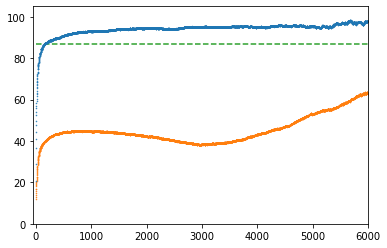

In [8]:
thres = None
colorz = ['#2ca02c', '#ff7f0e', '#1f77b4', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
legend_list = ['original HOTS', 'raw inputs','online HOTS']
namelist = ['raw', 'homhots']
fig_onl, ax_onl = plt.subplots()
ax_onl.hlines(86.9,0,6000, linestyles='dashed', color=colorz[0], label=legend_list[0])
for namnum, name in enumerate(namelist):
    f_name = f'{record_path}{timestr}_LR_results_{name}_{nbclust}_{nb_train}_{nb_test}_{ds_ev}.pkl'
    with open(f_name, 'rb') as file:
        likelihood, true_target = pickle.load(file)
    meanac, onlinac, lastac, truepos, falsepos = classification_results(likelihood, true_target, thres, nb_test)
    #pars, cov = curve_fit(f=fitting, xdata=np.arange(len(onlinac)), ydata=onlinac, p0=[1,1], bounds=(-np.inf, np.inf))
    #fit = fitting(np.arange(len(onlinac)), *pars) f
    print(f'Mean accuracy for {name}: {np.round(meanac,3)}')
    print(f'Last event accuracy for {name}: {np.round(lastac,3)}')
    ax_onl.plot(onlinac[:6000]*100, '.', ms=1, color=colorz[namnum+1], label = legend_list[namnum+1]);
    #ax_onl.plot(fit[:3000], linestyle='-', color=color[namnum], linewidth=1);
ax_onl.axis([-50,6000,0,105]);
plt.setp(ax_onl.get_yticklabels(), fontsize=12)
plt.setp(ax_onl.get_xticklabels(), fontsize=12)
ax_onl.set_xlabel('Number of events', fontsize=16);
ax_onl.set_ylabel('Accuracy (in %)', fontsize=16);
ax_onl.set_title('MLR classification evolution \n as a function of the number of events', fontsize=16);
ax_onl.legend(fontsize=12, loc='lower right');

In [10]:
ax_onl.axis([-50,6000,0,105]);
plt.setp(ax_onl.get_yticklabels(), fontsize=12)
plt.setp(ax_onl.get_xticklabels(), fontsize=12)
ax_onl.set_xlabel('Number of events', fontsize=16);
ax_onl.set_ylabel('Accuracy (in %)', fontsize=16);
ax_onl.set_title('MLR classification evolution \n as a function of the number of events', fontsize=16);
ax_onl.legend(fontsize=12, loc='lower right');
plt.show()

/home/antoine/homhots/HOTS/HOTS/Tools.py:522: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)


Mean accuracy for homhots: 0.954
Last event accuracy for homhots: 0.908


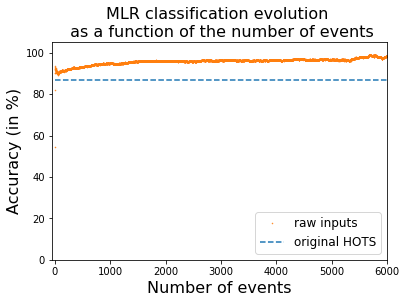

In [7]:
thres = 0.99
colorz = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
legend_list = ['original HOTS', 'raw inputs','online HOTS']
namelist = ['homhots','raw']
fig_onl, ax_onl = plt.subplots()
ax_onl.hlines(86.9,0,6000, linestyles='dashed', color=colorz[0], label=legend_list[0])
for namnum, name in enumerate(namelist):
    f_name = f'{record_path}{timestr}_LR_results_{name}_{nbclust}_{nb_train}_{nb_test}_{ds_ev}.pkl'
    with open(f_name, 'rb') as file:
        likelihood, true_target = pickle.load(file)
    meanac, onlinac, lastac, truepos, falsepos = classification_results(likelihood, true_target, thres, nb_test)
    #pars, cov = curve_fit(f=fitting, xdata=np.arange(len(onlinac)), ydata=onlinac, p0=[1,1], bounds=(-np.inf, np.inf))
    #fit = fitting(np.arange(len(onlinac)), *pars) f
    print(f'Mean accuracy for {name}: {np.round(meanac,3)}')
    print(f'Last event accuracy for {name}: {np.round(lastac,3)}')
    ax_onl.plot(onlinac[:6000]*100, '.', ms=1, color=colorz[namnum+1], label = legend_list[namnum+1]);
    #ax_onl.plot(fit[:3000], linestyle='-', color=color[namnum], linewidth=1);
ax_onl.axis([-50,6000,0,105]);
ax_onl.set_xlabel('Number of events', fontsize=16);
ax_onl.set_ylabel('Accuracy (in %)', fontsize=16);
ax_onl.set_title('MLR classification evolution \n as a function of the number of events', fontsize=16);
ax_onl.legend(fontsize=12, loc='lower right');

In [ ]:
thres = None
colorz = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
legend_list = ['original HOTS', 'raw inputs','online HOTS']
namelist = ['homhots','raw']
fig_onl, ax_onl = plt.subplots()
ax_onl.hlines(86.9,0,6000, linestyles='dashed', color=colorz[0], label=legend_list[0])
for namnum, name in enumerate(namelist):
    f_name = f'{record_path}{timestr}_LR_results_{name}_{nbclust}_{nb_train}_{nb_test}_{ds_ev}.pkl'
    with open(f_name, 'rb') as file:
        likelihood, true_target = pickle.load(file)
    meanac, onlinac, lastac, truepos, falsepos = classification_results(likelihood, true_target, thres, nb_test)
    #pars, cov = curve_fit(f=fitting, xdata=np.arange(len(onlinac)), ydata=onlinac, p0=[1,1], bounds=(-np.inf, np.inf))
    #fit = fitting(np.arange(len(onlinac)), *pars) f
    print(f'Mean accuracy for {name}: {np.round(meanac,3)}')
    print(f'Last event accuracy for {name}: {np.round(lastac,3)}')
    ax_onl.plot(onlinac[:6000]*100, '.', ms=1, color=colorz[namnum+1], label = legend_list[namnum+1]);
    #ax_onl.plot(fit[:3000], linestyle='-', color=color[namnum], linewidth=1);
ax_onl.axis([-50,6000,0,105]);
ax_onl.set_xlabel('Number of events', fontsize=16);
ax_onl.set_ylabel('Accuracy (in %)', fontsize=16);
ax_onl.set_title('MLR classification evolution \n as a function of the number of events', fontsize=16);
ax_onl.legend(fontsize=12, loc='lower right');

In [11]:
printfig(fig_onl, 'nmnist_online.pdf')

In [ ]:
namelist = ['raw', 'homhots']
for namnum, name in enumerate(namelist):
    f_name = f'{record_path}{timestr}_LR_results_{name}_{nbclust}_{nb_train}_{nb_test}_1.pkl'
    with open(f_name, 'rb') as file:
        likelihood, true_target, time_scale = pickle.load(file)
    nb_classes = 4
    timesteps = np.arange(500,100000,10)
    y_true = np.zeros([len(true_target)])
    y_score = np.zeros([len(true_target),nb_classes])
    proba_timestep = np.zeros([len(timesteps),len(true_target),nb_classes])
    i = 0
    for likelihood_, true_target_, time_scale_ in zip(likelihood, true_target, time_scale):
        time_scale_ -= time_scale_[0]
        previous_ind = 0
        for idx, step in enumerate(timesteps):
            ind = np.where(time_scale_<step)[0][-1]
            proba = np.mean(likelihood_[previous_ind:ind,:], axis=0)
            if np.isnan(proba[0]):
                print(step)
            proba_timestep[idx,i,:] = proba
        i+=1
    AUC = np.zeros([len(timesteps)])
    for idx, step in enumerate(timesteps):
        #print(proba_timestep[idx,:,:].shape, np.array(true_timestep[idx]))
        AUC[idx] = roc_auc_score(LabelBinarizer().fit_transform(np.array(true_target)),proba_timestep[idx,:,:], multi_class='ovr')
    plt.plot(timesteps,AUC, '.', label=name)
    plt.legend()

AUC at 1ms (end of the recording): 0.506
AUC at 295ms (end of the recording): 0.751
AUC at 100ms (end of the first saccade): 0.737
AUC at 1ms (end of the recording): 0.809
AUC at 295ms (end of the recording): 0.994
AUC at 100ms (end of the first saccade): 0.988


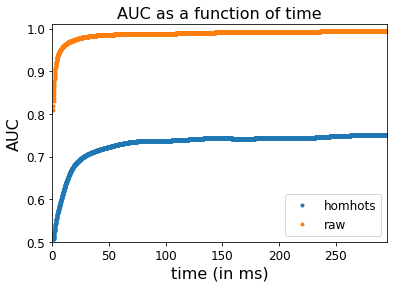

In [9]:
f_name = f'{record_path}{timestr}_LR_results_{nbclust}_{nb_train}_{nb_test}_1_AUC.pkl'
with open(f_name, 'rb') as file:
    results = pickle.load(file)

fig, ax = plt.subplots()
namelist = ['homhots', 'raw']
leg_list = ['online HOTS', 'MLR with raw inputs']
for namnum, name in enumerate(namelist):
    ax.plot(results[0][0]/1e3, results[0][namnum+1], '.', label=name)
    print(f'AUC at 1ms (end of the recording): {np.round(results[0][namnum+1][0],3)}')
    print(f'AUC at 295ms (end of the recording): {np.round(results[0][namnum+1][-1],3)}')
    print(f'AUC at 100ms (end of the first saccade): {np.round(results[0][namnum+1][990],3)}')
    
ax.axis([0,295,0.5,1.01]);
ax.set_xlabel('time (in ms)', fontsize=16);
ax.set_ylabel('AUC', fontsize=16);
plt.setp(ax.get_yticklabels(), fontsize=12)
plt.setp(ax.get_xticklabels(), fontsize=12)
ax.set_title('AUC as a function of time', fontsize=16);
ax.legend(fontsize=12, loc='lower right');

In [14]:
printfig(fig, 'nmnist_auc.pdf')

AUC at 1ms (end of the recording): 0.546
AUC at 295ms (end of the recording): 0.719
AUC at 100ms (end of the first saccade): 0.757
AUC at 1ms (end of the recording): 0.848
AUC at 295ms (end of the recording): 0.997
AUC at 100ms (end of the first saccade): 0.997


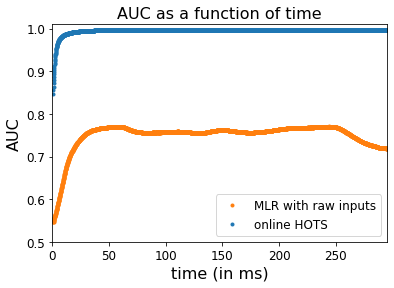

In [13]:
f_name = f'{record_path}{timestr}_LR_results_{nbclust}_{nb_train}_{nb_test}_1_AUC_nomean.pkl'
with open(f_name, 'rb') as file:
    results = pickle.load(file)

fig, ax = plt.subplots()
namelist = ['raw', 'hots', 'homhots']
leg_list = ['MLR with raw inputs', 'online HOTS', 'online homeo HOTS']
colorz = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
#for namnum, name in enumerate(namelist):
ax.plot(results[0][0]/1e3, results[0][1], '.', label=leg_list[0], color=colorz[1])
print(f'AUC at 1ms (end of the recording): {np.round(results[0][1][0],3)}')
print(f'AUC at 295ms (end of the recording): {np.round(results[0][1][-1],3)}')
print(f'AUC at 100ms (end of the first saccade): {np.round(results[0][1][990],3)}')
ax.plot(results[0][0]/1e3, results[0][3], '.', label=leg_list[1], color = colorz[0])
print(f'AUC at 1ms (end of the recording): {np.round(results[0][3][0],3)}')
print(f'AUC at 295ms (end of the recording): {np.round(results[0][3][-1],3)}')
print(f'AUC at 100ms (end of the first saccade): {np.round(results[0][3][990],3)}')
    
ax.axis([0,295,0.5,1.01]);
ax.set_xlabel('time (in ms)', fontsize=16);
ax.set_ylabel('AUC', fontsize=16);
plt.setp(ax.get_yticklabels(), fontsize=12)
plt.setp(ax.get_xticklabels(), fontsize=12)
ax.set_title('AUC as a function of time', fontsize=16);
ax.legend(fontsize=12, loc='lower right');

In [22]:
print(np.where(results[0][3][:]>0.997)[0][0])

938


In [23]:
results[0][0][938]

94800